# Latent Dirichlet Allocation (LDA)

In [1]:
import os
import re
import json
import gensim
import pyLDAvis
import random

import numpy as np
import pandas as pd

from gensim.models.ldamulticore import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel

import lib.helper as helper

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

import seaborn as sns
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "disaster" corpus works likewise, but with keywords relating to natural disasters

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "disaster"

# Load up
corpus = helper.load_clean_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 316
9.8 percent of files read.
19.6 percent of files read.
29.4 percent of files read.
39.2 percent of files read.
49.1 percent of files read.
58.9 percent of files read.
68.7 percent of files read.
78.5 percent of files read.
88.3 percent of files read.
98.1 percent of files read.
(22829, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,West Midlands <b>flood</b> warnings prompt &#3...,Residents have been warned to &quot;remain vig...,2019-11-17T17:35:00.0000000Z,https://www.bbc.co.uk/news/uk-england-50451817,www.bbc.co.uk,2019-11-17 19:50:58.278878,bing_news_api,West Midlands flood warnings prompt ;remain vi...
1,1,New <b>flood</b> warnings issued with more hom...,The Environment Agency has a number of <b>floo...,2019-11-17T18:35:00.0000000Z,https://www.hulldailymail.co.uk/news/hull-east...,www.hulldailymail.co.uk,2019-11-17 19:50:58.278928,bing_news_api,New flood warnings issued with more homes at r...
2,2,UK weather forecast – More than 100 <b>flood</...,<b>FLOOD</b>-ravaged villages in the UK have b...,2019-11-17T13:45:00.0000000Z,https://www.thesun.co.uk/news/10342583/uk-weat...,www.thesun.co.uk,2019-11-17 19:50:58.278953,bing_news_api,UK weather forecast – More than 100 flood aler...
3,5,UK <b>flood</b> warning map: <b>Flood</b> chao...,The Environment Agency has issued 57 <b>flood<...,2019-11-17T16:38:00.0000000Z,https://www.express.co.uk/news/weather/1205629...,www.express.co.uk,2019-11-17 19:50:58.279028,bing_news_api,UK flood warning map: Flood chaos to continue ...
4,6,UK weather forecast: <b>Flood</b> chaos contin...,Despite some areas enduring their &#39;wettest...,2019-11-17T18:32:00.0000000Z,https://www.mirror.co.uk/news/uk-news/uk-weath...,www.mirror.co.uk,2019-11-17 19:50:58.279047,bing_news_api,UK weather forecast: Flood chaos continues wit...


## 2.  Additional preprocessing for LDA

### TODO:  Dump the stuff below into another "embedding model" in lib

In [3]:
# A quick utility function to pre-process the text
def preprocess_desc(description):
    return( [stemmer.stem(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

corpus["tokens"] = corpus["clean_text"].apply(preprocess_desc)

corpus.tail()

,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text,tokens
node,,,,,,,,,,
22824,284779,Just one care home in Perth and Kinross curren...,The figures were revealed at a meeting of the ...,2020-06-23T07:22:00.0000000Z,https://www.dailyrecord.co.uk/news/local-news/...,www.dailyrecord.co.uk,2020-06-23 10:33:45.578751,bing_news_api,Just one care home in Perth and Kinross curren...,"[care, home, perth, kinross, current, deal, co..."
22825,284783,Biscuit factory which supplies McVities suffer...,A biscuit factory which supplies McVities has ...,2020-06-23T07:23:00.0000000Z,https://metro.co.uk/2020/06/23/biscuit-factory...,metro.co.uk,2020-06-23 10:33:45.578751,bing_news_api,Biscuit factory which supplies McVities suffer...,"[biscuit, factori, suppli, mcviti, suffer, cor..."
22826,284796,A coronavirus <b>outbreak</b> warning has been...,Workers at a major meat processing factory in ...,2020-06-22T16:52:00.0000000Z,https://www.birminghammail.co.uk/black-country...,www.birminghammail.co.uk,2020-06-23 10:33:45.578751,bing_news_api,A coronavirus outbreak warning has been issued...,"[coronaviru, outbreak, warn, issu, tulip, meat..."
22827,284797,John Cleese urges BBC to repeat Monty Python’s...,John Cleese has suggested that the BBC could p...,2020-06-22T17:06:00.0000000Z,https://www.belfasttelegraph.co.uk/entertainme...,www.belfasttelegraph.co.uk,2020-06-23 10:33:45.578751,bing_news_api,John Cleese urges BBC to repeat Monty Python’s...,"[john, clees, urg, bbc, repeat, monti, python,..."
22828,284804,NASCAR Drivers Join Together To Push Bubba Wal...,NASCAR drivers showed their support for fellow...,2020-06-23T06:59:00.0000000Z,https://www.unilad.co.uk/sport/nascar-drivers-...,www.unilad.co.uk,2020-06-23 10:33:45.579750,bing_news_api,NASCAR Drivers Join Together To Push Bubba Wal...,"[nascar, driver, join, push, bubba, wallac, ca..."


In [4]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(corpus['tokens'])

# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus['tokens']]

# From that create the TF-IDF model
# THIS IS ANOTHER POINT THE CORPUS ORDERING COULD DETATCH FROM THE RAW DATA ORDERING
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus['corpus_tfidf'] = tfidf[bow_corpus]

corpus['corpus_tfidf'].head()

node
0    [(0, 0.10943655526153134), (1, 0.1162270325171...
1    [(1, 0.23931894351010713), (2, 0.1188857516160...
2    [(2, 0.2294603107397069), (8, 0.14779115281367...
3    [(1, 0.13242509880518058), (2, 0.1315688359088...
4    [(8, 0.11964715573997439), (9, 0.2521568085669...
Name: corpus_tfidf, dtype: object

## 3. Testing a range of different-sized LDA models

In [5]:
random.seed(7)
trainset, testset = train_test_split(corpus, test_size=0.15)

In [6]:
# Loop through a number of different topic model sizes

results = pd.DataFrame()
for num_topics in range(3, 101):

    # Fit the lda model, with [num_topics] topics
    lda_model_tfidf = LdaModel(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    coherence = cm.get_coherence()
    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("working/disaster_lda_stats_clean.csv")

tried 3 topics perplexity = -9.644608370402382 coherence = -3.2301890904716335
tried 4 topics perplexity = -10.078326229430012 coherence = -3.1060949618466176
tried 5 topics perplexity = -10.475417360511877 coherence = -4.502097004437377
tried 6 topics perplexity = -10.849464187057832 coherence = -5.042396560558925
tried 7 topics perplexity = -11.08278173518284 coherence = -7.5718129553571405
tried 8 topics perplexity = -11.355639961241437 coherence = -7.667315603993724
tried 9 topics perplexity = -11.551831882443746 coherence = -8.553163457930188
tried 10 topics perplexity = -11.82433992829973 coherence = -9.325484138383716
tried 11 topics perplexity = -12.154514807024235 coherence = -7.636049274660636
tried 12 topics perplexity = -12.397685929174012 coherence = -10.697713400406066
tried 13 topics perplexity = -12.618003021594363 coherence = -9.999626000776594
tried 14 topics perplexity = -12.925374432649143 coherence = -11.598762968614327
tried 15 topics perplexity = -13.149680269455

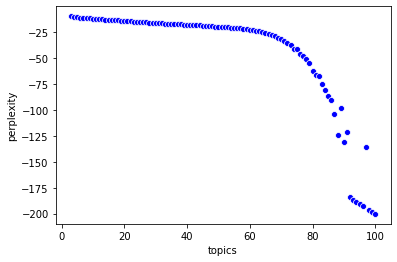

In [7]:
# plot the results - PERPLEXITY
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

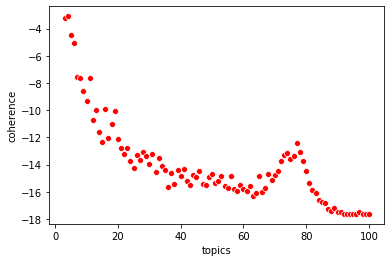

In [8]:
# plot the results - COHERENCE
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 4. Create the "best" model using all data

And parameters decided by test-time performance on perplexity and coherence.

In [9]:
random.seed(10)

# Fit the final lda model to all data
lda_model_tfidf = LdaModel(corpus['corpus_tfidf'],
                           num_topics=77,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(corpus['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=corpus['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

lda_model_tfidf.save("working/lda_model_tfidf.model")

perplexity = -50.61877846480941 coherence = -9.47128984296572


In [10]:
# Let's take a quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.031*"quot" + 0.031*"boss" + 0.028*"take" + 0.025*"pm" + 0.024*"consid" + 0.023*"cover" + 0.022*"play" + 0.021*"fan" + 0.021*"cent" + 0.020*"wednesday"
Topic: 1 Word: 0.190*"hope" + 0.077*"letter" + 0.072*"spent" + 0.069*"memori" + 0.048*"bradford" + 0.045*"favourit" + 0.037*"surround" + 0.034*"ride" + 0.027*"rebuild" + 0.020*"day"
Topic: 2 Word: 0.103*"avoid" + 0.098*"find" + 0.090*"suffer" + 0.075*"director" + 0.065*"execut" + 0.062*"limit" + 0.058*"good" + 0.051*"chanc" + 0.046*"heat" + 0.025*"say"
Topic: 3 Word: 0.000*"henley" + 0.000*"phil" + 0.000*"intent" + 0.000*"eli" + 0.000*"lifeboat" + 0.000*"feral" + 0.000*"hefti" + 0.000*"penni" + 0.000*"grim" + 0.000*"spiral"
Topic: 4 Word: 0.000*"henley" + 0.000*"phil" + 0.000*"intent" + 0.000*"eli" + 0.000*"lifeboat" + 0.000*"feral" + 0.000*"hefti" + 0.000*"penni" + 0.000*"grim" + 0.000*"spiral"
Topic: 5 Word: 0.107*"second" + 0.079*"hurrican" + 0.054*"believ" + 0.047*"anim" + 0.046*"island" + 0.045*"safe" + 0.039*"end" 

In [11]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    # Record the topic index in a format R will like
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character while we're at it!
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)
    
topic_word_dist

,keywords,topic
0,quot boss take pm consid,X0
1,hope letter spent memori bradford,X1
2,avoid find suffer director execut,X2
3,henley phil intent eli lifeboat,X3
4,henley phil intent eli lifeboat,X4
...,...,...
72,busi leader move parti fast,X72
73,henley phil intent eli lifeboat,X73
74,henley phil intent eli lifeboat,X74
75,lead tourist zealand possibl small,X75


In [12]:
# Assign topic to document, also store the probability of that topic
doc_topics = []

count = 0
for index, row in corpus.iterrows():
    
    # Extract list of tuples of (topic, score) from the model for each doc
    topics = [x for x in lda_model_tfidf.get_document_topics(row['corpus_tfidf']) ]
    
    # Find the highest probability topic
    highest_scoring = sorted(topics, key=lambda x: x[1], reverse=True)[0]
    
    temp = {"node": int(index),
            "cluster": highest_scoring[0],
            "score": highest_scoring[1]}
    
    # Report processing progress!
    count = count + 1
    if count % 10000 == 0:
        print(count)
    
    doc_topics.append(temp)

doc_topic_dist = pd.DataFrame(doc_topics).set_index("node")

#doc_topic_dist.to_csv("working/doc_topic_dist_backup.csv")
#doc_topic_dist.head()

10000
20000


In [13]:
corpus.join(doc_topic_dist).to_csv("working/disaster_clustered_lda.csv", index=False)

### Looking at the topic distribution, there's no obvious way to draw a line and cut off outliers

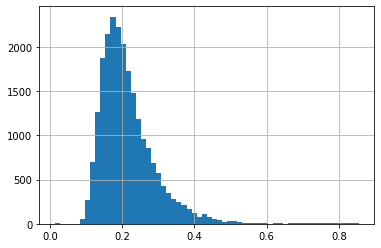

In [14]:
corpus.join(doc_topic_dist)['score'].hist(bins=60)